To enhance efficiency in reading files concurrently from the disk, the concurrent.futures module is employed, enabling multithreaded execution for faster data retrieval. This approach optimizes performance, particularly when dealing with large datasets, by efficiently utilizing multiple CPU cores.

In [1]:
import os
from glob import glob
from concurrent import futures
import numpy as np

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from threading import Lock
from multiprocessing import Value

[nltk_data] Downloading package punkt to C:\Users\Proshir-
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Proshir-
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Initialization:
the categories list is defined to represent the sentiment classes within the dataset, namely 'neg' for negative sentiment and 'pos' for positive sentiment. The NLTK library's stopwords corpus is utilized to create a set of stopwords in English. These stopwords include common words like 'the', 'is', and 'are', which often convey little semantic meaning and are typically removed during text preprocessing. Additionally, the '\<br\>' tag, commonly found in HTML documents, is also added to the set of stopwords to ensure its exclusion from the text data. 


In [3]:
dataset_path = 'aclImdb'
categories = ['neg', 'pos']

In [4]:
stop_words = set(stopwords.words('english'))
stop_words.add('br')

## Preprocess Document
The preprocess_document function tokenizes, removes punctuation and stop words, and performs stemming on a given document. It returns two outputs: one with stemming applied and the other without stemming for continued research or analysis.

The counter and lock parameters are used to ensure thread safety when updating a shared counter variable that tracks the number of documents processed. Since multiple threads may simultaneously access and update the counter, the lock object is employed to prevent race conditions. By acquiring the lock before updating the counter, we ensure that only one thread can modify the counter at a time, maintaining consistency in the count of processed documents across threads..

In [5]:
def preprocess_document(doc):
    # Tokenization
    words = word_tokenize(doc.lower())
    
    # Remove punctuation and stop words
    words = [word for word in words if word.isalnum() and word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    return ' '.join(stemmed_words), ' '.join(words)

## Load Document
The load_doc function loads and preprocesses a single document from the specified path, along with its identifier and label. To ensure thread safety when updating the shared counter variable, a lock is used. The counter variable tracks the total number of files loaded, with a message printed every 1000 files to indicate progress.

In [6]:
def load_doc(path, id_label, counter, lock):
    doc = open(path, 'r', encoding='utf-8').read()
    
    doc, doc_nst = preprocess_document(doc)
    
    with lock:
        counter.value += 1
        if counter.value % 1000 == 0:
            print(f"Loaded {counter.value} files so far.")
            
    return doc, doc_nst, id_label

The variable w_cpu is assigned the number of CPU cores available on the system using the os.cpu_count() function. This value represents the maximum number of CPU cores that can be utilized for multithreaded processing. By leveraging this value, the program can efficiently distribute tasks across multiple CPU cores, maximizing computational throughput and performance.

In [7]:
w_cpu = os.cpu_count()
w_cpu

12

## Load Dataset

The load_dataset function efficiently loads a text dataset from the specified c_path directory using multithreading for faster reading. The function constructs file paths, initializes shared variables for counting and thread safety, and utilizes a ThreadPoolExecutor for concurrent execution of document loading tasks.

By leveraging multithreading, the function asynchronously loads documents from each category within the dataset in parallel, significantly speeding up the reading process. This approach maximizes CPU utilization and minimizes I/O wait time, leading to faster data retrieval. The function returns lists of documents with and without stemming, along with their corresponding labels, facilitating subsequent analysis and classification tasks.

In [8]:
def load_dataset(c_path):
    path = os.path.join(dataset_path, c_path)
    docs, doc_nsts, labels = [], [], []
    counter = Value('i', 0)  # Shared counter
    lock = Lock()  # Lock for thread safety
    with futures.ThreadPoolExecutor() as executor:
        tasks = [executor.submit(load_doc, fpath, id_label, counter, lock) 
                 for id_label, label in enumerate(categories) 
                     for fpath in glob(os.path.join(path, label, '*.txt'))]
        for future in futures.as_completed(tasks):
            doc, doc_nst, label = future.result()
            docs += [doc]
            doc_nsts += [doc_nst]
            labels += [label]
    return docs, doc_nsts, np.array(labels, np.int8)

In [9]:
x_trn, x_nst_trn, y_trn = load_dataset('train')
display(y_trn)
display(len(x_trn))

Loaded 1000 files so far.
Loaded 2000 files so far.
Loaded 3000 files so far.
Loaded 4000 files so far.
Loaded 5000 files so far.
Loaded 6000 files so far.
Loaded 7000 files so far.
Loaded 8000 files so far.
Loaded 9000 files so far.
Loaded 10000 files so far.
Loaded 11000 files so far.
Loaded 12000 files so far.
Loaded 13000 files so far.
Loaded 14000 files so far.
Loaded 15000 files so far.
Loaded 16000 files so far.
Loaded 17000 files so far.
Loaded 18000 files so far.
Loaded 19000 files so far.
Loaded 20000 files so far.
Loaded 21000 files so far.
Loaded 22000 files so far.
Loaded 23000 files so far.
Loaded 24000 files so far.
Loaded 25000 files so far.


array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

25000

### The Impact of Stemming on Text Normalization:Stemming, a crucial step in text preprocessing, plays a pivotal role in standardizing text for analysis and classification tasks. In this analysis, the application of stemming is explored through a comparison of text passages before and after stemming. By reducing words to their root form, stemming enhances text coherence and simplifies vocabulary, facilitating more efficient and effective text analysis processes. Through this investigation, the significance of stemming in optimizing text normalization techniques is underscored, highlighting its utility in enhancing the accuracy and robustness of natural language processing applications.


In [10]:
x_trn[0]

'bill crain rarer rare movi certainli follow standard stalk slash guidelin becom essenti counterpart bogeyman time around use grenad small arm well awesom array mele weapon sin virtual unaccept genr piec still enough familiar keep slasher buff check rule book plot never stray far path grown expect walli koz surprisingli decent 555 seemingli put togeth help variou member famili mirag seem joint product rel director look credit notic numer list key posit throughout construct featur despit fairli good distribut across globe movi fail make impress either side atlant becom pretti much phantom vh market nevertheless made appeal even strain resourc track copi take place middl dessert sure agre hardli excit locat said though must admit certainli go chanc nosey john q law turn unexpectedli four undeni beauti youngster head sand night debaucheri frolic alway seem rub homicid maniac wrong way chri jennif mcallist boyfriend greg kenni johnson meet amus new age hippi trip kevin mcparland mari nicol

In [11]:
x_nst_trn[0]

'bill crain rarer rare movie certainly follow standard stalk slash guidelines become essential counterparts bogeyman time around uses grenades small arms well awesome array melee weapons sin virtually unacceptable genre pieces still enough familiarity keep slasher buffs checking rule book plot never strays far path grown expect wally koz surprisingly decent 555 seemingly put together help various members family mirage seems joint production relatives director looking credits noticed numerous listed key positions throughout construction feature despite fairly good distribution across globe movie failed make impression either side atlantic become pretty much phantom vhs market nevertheless made appeal even strained resources track copy takes place middle dessert sure agree hardly exciting location said though must admit certainly going chance nosey john q laws turning unexpectedly four undeniably beautiful youngsters head sand night debauchery frolics always seems rub homicidal maniacs w

In [12]:
x_tst, x_nst_tst, y_tst = load_dataset('test')
display(y_tst)
display(len(x_tst))

Loaded 1000 files so far.
Loaded 2000 files so far.
Loaded 3000 files so far.
Loaded 4000 files so far.
Loaded 5000 files so far.
Loaded 6000 files so far.
Loaded 7000 files so far.
Loaded 8000 files so far.
Loaded 9000 files so far.
Loaded 10000 files so far.
Loaded 11000 files so far.
Loaded 12000 files so far.
Loaded 13000 files so far.
Loaded 14000 files so far.
Loaded 15000 files so far.
Loaded 16000 files so far.
Loaded 17000 files so far.
Loaded 18000 files so far.
Loaded 19000 files so far.
Loaded 20000 files so far.
Loaded 21000 files so far.
Loaded 22000 files so far.
Loaded 23000 files so far.
Loaded 24000 files so far.
Loaded 25000 files so far.


array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

25000

In [13]:
x_tst[0]

'dant would mortifi knew masterpiec act puppet also actor play puppet sell out due fact play puppet act basic noth one realli care puppet peopl care play major role like actual movi annoy could mock amaz man belief dumb littl movi crime cant believ would ruin book like thought movi absolut ridicul destroy total ruin suppos get read make big joke'

### Exploring Word Distribution in Positive and Negative Sentiment Categories

Now, I aim to illustrate the distribution of words for positive and negative sentiment categories within the training dataset. By conducting this analysis, we can discern the frequency of occurrence for each word in both sentiment classes, shedding light on the vocabulary composition for each sentiment category. This exploration will provide valuable insights into the language patterns associated with positive and negative sentiments, aiding in the development of more nuanced and contextually aware text classification models.

In [14]:
docs_nst = np.asarray([doc for doc in x_nst_trn])
docs_nst

array(['bill crain rarer rare movie certainly follow standard stalk slash guidelines become essential counterparts bogeyman time around uses grenades small arms well awesome array melee weapons sin virtually unacceptable genre pieces still enough familiarity keep slasher buffs checking rule book plot never strays far path grown expect wally koz surprisingly decent 555 seemingly put together help various members family mirage seems joint production relatives director looking credits noticed numerous listed key positions throughout construction feature despite fairly good distribution across globe movie failed make impression either side atlantic become pretty much phantom vhs market nevertheless made appeal even strained resources track copy takes place middle dessert sure agree hardly exciting location said though must admit certainly going chance nosey john q laws turning unexpectedly four undeniably beautiful youngsters head sand night debauchery frolics always seems rub homicidal ma

In [15]:
pos_words = [word for doc in docs_nst[y_trn == 1] for word in doc.split(' ')]
pos_words

['bill',
 'crain',
 'rarer',
 'rare',
 'movie',
 'certainly',
 'follow',
 'standard',
 'stalk',
 'slash',
 'guidelines',
 'become',
 'essential',
 'counterparts',
 'bogeyman',
 'time',
 'around',
 'uses',
 'grenades',
 'small',
 'arms',
 'well',
 'awesome',
 'array',
 'melee',
 'weapons',
 'sin',
 'virtually',
 'unacceptable',
 'genre',
 'pieces',
 'still',
 'enough',
 'familiarity',
 'keep',
 'slasher',
 'buffs',
 'checking',
 'rule',
 'book',
 'plot',
 'never',
 'strays',
 'far',
 'path',
 'grown',
 'expect',
 'wally',
 'koz',
 'surprisingly',
 'decent',
 '555',
 'seemingly',
 'put',
 'together',
 'help',
 'various',
 'members',
 'family',
 'mirage',
 'seems',
 'joint',
 'production',
 'relatives',
 'director',
 'looking',
 'credits',
 'noticed',
 'numerous',
 'listed',
 'key',
 'positions',
 'throughout',
 'construction',
 'feature',
 'despite',
 'fairly',
 'good',
 'distribution',
 'across',
 'globe',
 'movie',
 'failed',
 'make',
 'impression',
 'either',
 'side',
 'atlantic',
 'b

In [16]:
neg_words = [word for doc in docs_nst[y_trn == 0] for word in doc.split(' ')]
neg_words

['ladies',
 'gentlemen',
 'please',
 'get',
 'fooled',
 'stanley',
 'kubrick',
 'film',
 'bad',
 'film',
 'unfortunately',
 'hailed',
 'one',
 'deadliest',
 'horror',
 'films',
 'ever',
 'films',
 'create',
 'fear',
 'nights',
 'people',
 'shiver',
 'hearts',
 'thinking',
 'true',
 'horror',
 'shining',
 'real',
 'horror',
 'find',
 'instead',
 'naive',
 'foolish',
 'attempt',
 'made',
 'create',
 'chilling',
 'knows',
 'good',
 'attempts',
 'different',
 'good',
 'film',
 'view',
 'icy',
 'valley',
 'hotel',
 'actors',
 'lodged',
 'appears',
 'good',
 'word',
 'actors',
 'jack',
 'nicholson',
 'looks',
 'like',
 'lost',
 'lazy',
 'soul',
 'never',
 'really',
 'sure',
 'supposed',
 'much',
 'said',
 'bald',
 'colored',
 'actor',
 'times',
 'busy',
 'pampering',
 'kid',
 'need',
 'blame',
 'bad',
 'weather',
 'avoided',
 'film',
 'made',
 'poor',
 'kubrick',
 'alive',
 'make',
 'changes',
 'watched',
 'phat',
 'beach',
 'cable',
 'sort',
 'enjoyed',
 'fat',
 'guy',
 'best',
 'character'

In [17]:
from nltk import FreqDist

In [18]:
fd_pos = nltk.FreqDist(p for p in pos_words)
fd_neg = nltk.FreqDist(n for n in neg_words)

In [19]:
most_common_pos = fd_pos.most_common(30)
most_common_neg = fd_neg.most_common(30)

In [20]:
! pip install matplotlib

In [21]:
import matplotlib.pyplot as plt

### Analyzing Word Frequency Distributions in Positive and Negative Reviews
In this analysis, we compute frequency distributions of words in both positive and negative reviews to identify the 30 most common words in each sentiment category. By examining the prevalence of words across positive and negative sentiment classes, we aim to discern distinct language patterns associated with each sentiment. Notably, we observe that common words such as "film" and "movie" exhibit high frequencies in both positive and negative reviews, suggesting their widespread usage across sentiment categories. This exploration provides valuable insights into the prominent themes and language features characterizing positive and negative sentiments in the dataset, facilitating a deeper understanding of textual dynamics for sentiment analysis tasks.

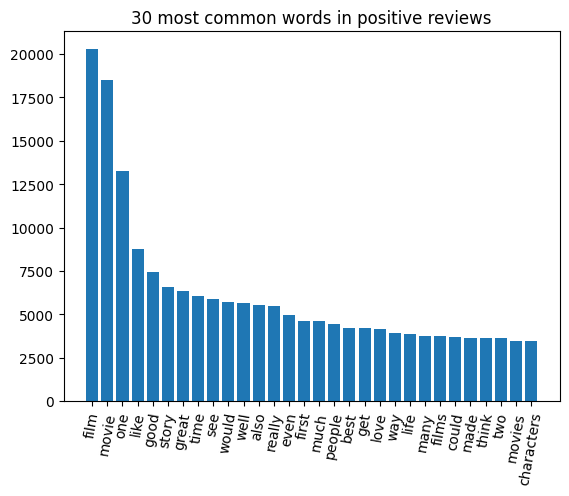

In [22]:
plt.bar(range(len(most_common_pos)), [val[1] for val in most_common_pos])
plt.xticks(range(len(most_common_pos)), [val[0] for val in most_common_pos])
plt.xticks(rotation=80)
plt.title('30 most common words in positive reviews')
plt.show()

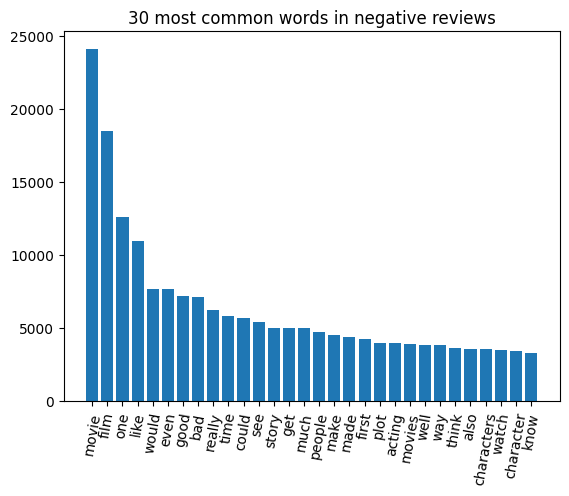

In [23]:
plt.bar(range(len(most_common_neg)), [val[1] for val in most_common_neg])
plt.xticks(range(len(most_common_neg)), [val[0] for val in most_common_neg])
plt.xticks(rotation=80)
plt.title('30 most common words in negative reviews')
plt.show()

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

The function say_category(idx_cat) maps an index to its corresponding sentiment category, providing a succinct and efficient means of identifying sentiment categories based on their index values.

In [25]:
def say_category(idx_cat):
    return categories[idx_cat]

### Evaluating Classification Performance Metrics
The say_measurement function calculates and prints key classification performance metrics, including accuracy, precision, recall, and F1-score, based on true labels and predicted labels. This comprehensive evaluation provides insights into the effectiveness and robustness of the classification model in accurately predicting sentiment categories.

In [26]:
!pip install pandas

In [27]:
import pandas as pd

C:\Users\Proshir-Pc\AppData\Local\Temp\ipykernel_14912\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [28]:
def say_measurement(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    metrics_table = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Value': [accuracy, precision, recall, f1]
    })
    
    return metrics_table

### Vectorizing Text Data
The code snippet utilizes the CountVectorizer to convert text data into numerical feature vectors for training and evaluating classification models. The fit_transform method is applied to the training data (x_trn), while the transform method is used on the test data (x_tst), enabling efficient processing of textual data for machine learning algorithms.

In [29]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(x_trn)

In [30]:
X_test = vectorizer.transform(x_tst)

## Utilizing Multinomial Naive Bayes
Initially, we utilize the Multinomial Naive Bayes classifier (MultinomialNB) for text classification tasks. However, for subsequent experiments and implementations, we construct a custom Naive Bayes classifier from scratch to gain deeper insights into its functionality and tailor its behavior to specific requirements. This approach allows for greater flexibility and customization in adapting the classifier to different datasets and problem domains.

In [31]:
classifier = MultinomialNB()
classifier.fit(X_train, y_trn)

MultinomialNB()

Upon employing the Naive Bayes classifier on the training dataset and evaluating its performance metrics, it achieves an accuracy score of 1.0. This outcome is attributed to the classifier's utilization of a static formula to compute predictions, resulting in a complete match between predicted and actual labels.

In [32]:
predicted_labels = classifier.predict(X_train)
say_measurement(y_trn, predicted_labels)

,Metric,Value
0,Accuracy,0.897840
1,Precision,0.898892
2,Recall,0.897840
3,F1-score,0.897773


In [33]:
predicted_labels = classifier.predict(X_test)

In [34]:
display(predicted_labels[0])
say_category(predicted_labels[0])

0

'neg'

In [35]:
say_measurement(y_tst, predicted_labels)

,Metric,Value
0,Accuracy,0.816880
1,Precision,0.820940
2,Recall,0.816880
3,F1-score,0.816299


In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_tst, predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.87      0.83     12500
           1       0.86      0.76      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



## Utilizing Custom Naive Bayes Classifier
In this step, we employ our custom Naive Bayes classifier for sentiment analysis. This classifier utilizes logarithmic operations to handle division and multiplication, ensuring numerical stability. Additionally, we incorporate Laplace smoothing by adding a pseudocount of 1 to prevent division by zero and enhance the model's robustness. During the fitting process, the classifier calculates label probabilities and word probabilities based on the training data, facilitating sentiment prediction. Subsequently, when making predictions on the test dataset, the model computes label scores for each document and selects the label with the highest score as the predicted sentiment. Through these mechanisms, our custom Naive Bayes classifier effectively learns from the training data and provides accurate sentiment predictions on unseen documents.r

In [38]:
class MyNaiveBayes:
    def fit(self, x_train, y_train):
        self.labels, label_counts = np.unique(y_train, return_counts=True)
        display(self.labels)
        display(label_counts)
        
        self.word_counts = {label: np.array(np.sum(X_train[y_train == label], axis=0)).flatten() for label in self.labels}

        print(self.word_counts)
        
        total_docs = len(y_train)
        self.label_probs = np.log(label_counts) - np.log(total_docs)
        print(self.label_probs)

        num_unique_words = len(self.word_counts[1])
        print(num_unique_words)
        
        total_words_in_labels = {label: np.sum(self.word_counts[label]) for label in self.labels}
        self.word_probs = {label: np.log(self.word_counts[label] + 1) - np.log(total_words_in_labels[label] + num_unique_words)
                                  for label in self.labels}

        print(self.word_probs)

    def predict(self, x_test):
        predicts = []
        for doc in x_test:
            label_scores = [ self.label_probs[label] +
                            np.sum(doc * self.word_probs[label])
                for label in self.labels]
            predicts += [np.argmax(label_scores)]
        return predicts

In [39]:
classifier = MyNaiveBayes()

In [40]:
classifier.fit(X_train, y_trn)

array([0, 1], dtype=int8)

array([12500, 12500], dtype=int64)

{0: array([2, 1, 1, ..., 0, 2, 1], dtype=int64), 1: array([2, 0, 0, ..., 1, 0, 0], dtype=int64)}
[-0.69314718 -0.69314718]
49493
{0: array([-13.09454672, -13.50001183, -13.50001183, ..., -14.19315901,
       -13.09454672, -13.50001183]), 1: array([-13.13583884, -14.23445113, -14.23445113, ..., -13.54130395,
       -14.23445113, -14.23445113])}


In [41]:
predicted_labels = classifier.predict(X_train)
say_measurement(y_trn, predicted_labels)

,Metric,Value
0,Accuracy,0.897840
1,Precision,0.898892
2,Recall,0.897840
3,F1-score,0.897773


In [42]:
predicted_labels = classifier.predict(X_test)
predicted_labels

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [43]:
say_measurement(y_tst, predicted_labels)

,Metric,Value
0,Accuracy,0.816880
1,Precision,0.820940
2,Recall,0.816880
3,F1-score,0.816299


## Utilizing Word Embeddings and SVM for Sentiment Classification
Transitioning from traditional approaches, we now leverage word embeddings with Support Vector Machines (SVM) to enhance sentiment classification accuracy. Specifically, we compare FastText and Word2Vec embeddings, aiming to discern the most effective technique for capturing semantic relationships. By representing words in a continuous vector space, these embeddings enrich feature representation, facilitating a more nuanced sentiment analysis process. Through this comparative study, we aim to identify the optimal word embedding method for sentiment classification tasks.n

In [44]:
!pip install gensim

In [45]:
from gensim.models import Word2Vec, FastText
from sklearn.svm import SVC

### Base Class for Embeddings InitializationnIntroducing a base class for embeddings, we streamline the process of utilizing both Word2Vec and FastText models. The class is equipped with parameters to configure the model's behavior, such as window size, minimum word count, and the number of worker threads. Through the setup method, the model is initialized and trained using the provided training dataset, while also generating embeddings for both the training and test datasets. This abstraction simplifies the usage of Word2Vec and FastText models within our sentiment analysis framework, promoting code reusability and efficiency..

In [46]:
class Embeddings:
    def __init__(self, Model, window=10, min_count=2, workers=12):
        self.model = None
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.Model = Model
        
    def setup(self, x_train, x_test):
        self.model = self.Model(x_train, window=self.window, min_count=self.min_count, workers=self.workers)
        self.x_train_embeddings = self._get_doc_embeddings_parallel(x_train)
        self.x_test_embeddings = self._get_doc_embeddings_parallel(x_test)

### Word2Vec Embeddings
Utilizing multithreading to expedite the embedding process, the Word2VecEmbeddings class inherits from the base Embeddings class and specializes in employing Word2Vec embeddings. By leveraging the Word2Vec model, this implementation captures semantic information from the training dataset. The _get_doc_embeddings_parallel method employs a multithreaded approach to efficiently compute document embeddings, enhancing performance by leveraging parallel processing capabilities. Specifically, it utilizes the mean vector of Word2Vec embeddings for each word in the document to generate the document-level embedding. This strategy optimizes the efficiency of sentiment analysis tasks by leveraging the capabilities of the Word2Vec model in a parallelized manner...

In [47]:
class Word2VecEmbeddings(Embeddings):
    def __init__(self, window=10, min_count=2, workers=12):
        super().__init__(Word2Vec, window=window, min_count=min_count, workers=workers)

    def _get_doc_embeddings_parallel(self, documents):
        with futures.ThreadPoolExecutor(max_workers=self.workers) as executor:
            embeddings = list(executor.map(self.model.wv.get_mean_vector, documents))
        return embeddings

## SVM with Word Embedding
The WordEmbeddingsSVM class is designed to integrate word embeddings with a Support Vector Machine (SVM) classifier for sentiment analysis tasks. It accepts precomputed word embeddings as input, facilitating flexibility and interoperability with various embedding techniques. During initialization, it receives an instance of precomputed word embeddings. The fit method trains the SVM classifier using the training embeddings, while the predict_train method predicts labels for the training data. Similarly, the predict method predicts labels for the test data using the trained SVM classifier. This modular design enables seamless integration of word embeddings with SVM classification, offering a powerful framework for sentiment analysis tasks.

In [48]:
class WordEmbeddingsSVM:
    def __init__(self, word_embeddings):
        self.word_embeddings = word_embeddings
        self.svm_classifier = SVC()

    def fit(self, y_train):
        self.svm_classifier.fit(self.word_embeddings.x_train_embeddings, y_train)        

    def predict_train(self):
        return self.svm_classifier.predict(self.word_embeddings.x_train_embeddings)
    
    def predict(self):
        return self.svm_classifier.predict(self.word_embeddings.x_test_embeddings)

#### Converting Documents to Word Lists:
For effective utilization of techniques like Word2Vec and FastText, each document is transformed into a list of individual words rather than remaining as plain text. The convert_to_words function efficiently performs this conversion, ensuring that each document is represented as a list of its constituent words. This preprocessing step is essential for subsequent tasks such as word embedding generation and machine learning model training, enabling these techniques to effectively capture semantic relationships within the text data.


In [49]:
def convert_to_words(docs):
    with futures.ThreadPoolExecutor(max_workers=w_cpu) as executor:
        word_lists = list(executor.map(lambda doc: doc.split(), docs))
    return word_lists

In [50]:
x_train = convert_to_words(x_trn)
x_train[0]

['bill',
 'crain',
 'rarer',
 'rare',
 'movi',
 'certainli',
 'follow',
 'standard',
 'stalk',
 'slash',
 'guidelin',
 'becom',
 'essenti',
 'counterpart',
 'bogeyman',
 'time',
 'around',
 'use',
 'grenad',
 'small',
 'arm',
 'well',
 'awesom',
 'array',
 'mele',
 'weapon',
 'sin',
 'virtual',
 'unaccept',
 'genr',
 'piec',
 'still',
 'enough',
 'familiar',
 'keep',
 'slasher',
 'buff',
 'check',
 'rule',
 'book',
 'plot',
 'never',
 'stray',
 'far',
 'path',
 'grown',
 'expect',
 'walli',
 'koz',
 'surprisingli',
 'decent',
 '555',
 'seemingli',
 'put',
 'togeth',
 'help',
 'variou',
 'member',
 'famili',
 'mirag',
 'seem',
 'joint',
 'product',
 'rel',
 'director',
 'look',
 'credit',
 'notic',
 'numer',
 'list',
 'key',
 'posit',
 'throughout',
 'construct',
 'featur',
 'despit',
 'fairli',
 'good',
 'distribut',
 'across',
 'globe',
 'movi',
 'fail',
 'make',
 'impress',
 'either',
 'side',
 'atlant',
 'becom',
 'pretti',
 'much',
 'phantom',
 'vh',
 'market',
 'nevertheless',
 'm

In [51]:
x_test = convert_to_words(x_tst)
x_test[0]

['dant',
 'would',
 'mortifi',
 'knew',
 'masterpiec',
 'act',
 'puppet',
 'also',
 'actor',
 'play',
 'puppet',
 'sell',
 'out',
 'due',
 'fact',
 'play',
 'puppet',
 'act',
 'basic',
 'noth',
 'one',
 'realli',
 'care',
 'puppet',
 'peopl',
 'care',
 'play',
 'major',
 'role',
 'like',
 'actual',
 'movi',
 'annoy',
 'could',
 'mock',
 'amaz',
 'man',
 'belief',
 'dumb',
 'littl',
 'movi',
 'crime',
 'cant',
 'believ',
 'would',
 'ruin',
 'book',
 'like',
 'thought',
 'movi',
 'absolut',
 'ridicul',
 'destroy',
 'total',
 'ruin',
 'suppos',
 'get',
 'read',
 'make',
 'big',
 'joke']

#### Creating Word2Vec Embeddings Instance




When using Word2VecEmbeddings, we first initialize an instance of the Word2VecEmbeddings class with the specified parameters, such as the window size, minimum word count, and number of workers (threads). This initialization sets up the Word2Vec model and prepares it for training.

In [52]:
word_embeddings_w2v = Word2VecEmbeddings(window=10, min_count=2, workers=w_cpu)

In [53]:
word_embeddings_w2v.setup(x_train, x_test)

In [54]:
word_embeddings_w2v.model.wv.key_to_index

{'movi': 0,
 'film': 1,
 'one': 2,
 'like': 3,
 'time': 4,
 'good': 5,
 'make': 6,
 'get': 7,
 'see': 8,
 'charact': 9,
 'watch': 10,
 'would': 11,
 'even': 12,
 'stori': 13,
 'realli': 14,
 'scene': 15,
 'well': 16,
 'look': 17,
 'show': 18,
 'much': 19,
 'could': 20,
 'end': 21,
 'peopl': 22,
 'also': 23,
 'go': 24,
 'great': 25,
 'bad': 26,
 'first': 27,
 'think': 28,
 'love': 29,
 'play': 30,
 'way': 31,
 'act': 32,
 'thing': 33,
 'made': 34,
 'say': 35,
 'know': 36,
 'seem': 37,
 'work': 38,
 'mani': 39,
 'two': 40,
 'plot': 41,
 'come': 42,
 'actor': 43,
 'want': 44,
 'seen': 45,
 'take': 46,
 'never': 47,
 'littl': 48,
 'year': 49,
 'tri': 50,
 'best': 51,
 'life': 52,
 'ever': 53,
 'give': 54,
 'man': 55,
 'still': 56,
 'better': 57,
 'find': 58,
 'perform': 59,
 'feel': 60,
 'part': 61,
 'use': 62,
 'actual': 63,
 'someth': 64,
 'back': 65,
 'interest': 66,
 'lot': 67,
 'director': 68,
 'real': 69,
 'though': 70,
 'cast': 71,
 'anoth': 72,
 'enjoy': 73,
 'live': 74,
 'noth': 7

#### Creating SVM Model Using Word2Vec Embeddings





In [55]:
svm_w2v = WordEmbeddingsSVM(word_embeddings_w2v)

In [56]:
svm_w2v.fit(y_trn)

In [57]:
y_pred = svm_w2v.predict_train()
say_measurement(y_trn, y_pred)

,Metric,Value
0,Accuracy,0.876800
1,Precision,0.876915
2,Recall,0.876800
3,F1-score,0.876791


In [58]:
y_pred = svm_w2v.predict()
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [59]:
say_measurement(y_tst, y_pred)

,Metric,Value
0,Accuracy,0.860880
1,Precision,0.860988
2,Recall,0.860880
3,F1-score,0.860870


### FastText
t
FastText is an extension of the Word2Vec model that takes into account subword information by breaking words into smaller character n-grams. In FastText, unlike Word2Vec, the model utilizes the get_sentence_vector function to obtain the vector representation of a sentence directly. This approach allows FastText to capture the meaning of out-of-vocabulary words by aggregating the vectors of their constituent character n-grams, making it particularly effective for handling misspellings, morphological variations, and rare words.

In [60]:
from gensim.models.fasttext import FastText

In [61]:
class FastTextEmbeddings(Embeddings):
    def __init__(self, window=10, min_count=2, workers=12):
        super().__init__(FastText, window=window, min_count=min_count, workers=workers)

    def _get_doc_embeddings_parallel(self, documents):
        with futures.ThreadPoolExecutor(max_workers=self.workers) as executor:
            embeddings = list(executor.map(self.model.wv.get_sentence_vector, documents))
        return embeddings

In [62]:
word_embeddings_ft = FastTextEmbeddings(window=10, min_count=2, workers=w_cpu)

In [63]:
word_embeddings_ft.setup(x_train, x_test)

In [64]:
word_embeddings_ft.model.wv.key_to_index

{'movi': 0,
 'film': 1,
 'one': 2,
 'like': 3,
 'time': 4,
 'good': 5,
 'make': 6,
 'get': 7,
 'see': 8,
 'charact': 9,
 'watch': 10,
 'would': 11,
 'even': 12,
 'stori': 13,
 'realli': 14,
 'scene': 15,
 'well': 16,
 'look': 17,
 'show': 18,
 'much': 19,
 'could': 20,
 'end': 21,
 'peopl': 22,
 'also': 23,
 'go': 24,
 'great': 25,
 'bad': 26,
 'first': 27,
 'think': 28,
 'love': 29,
 'play': 30,
 'way': 31,
 'act': 32,
 'thing': 33,
 'made': 34,
 'say': 35,
 'know': 36,
 'seem': 37,
 'work': 38,
 'mani': 39,
 'two': 40,
 'plot': 41,
 'come': 42,
 'actor': 43,
 'want': 44,
 'seen': 45,
 'take': 46,
 'never': 47,
 'littl': 48,
 'year': 49,
 'tri': 50,
 'best': 51,
 'life': 52,
 'ever': 53,
 'give': 54,
 'man': 55,
 'still': 56,
 'better': 57,
 'find': 58,
 'perform': 59,
 'feel': 60,
 'part': 61,
 'use': 62,
 'actual': 63,
 'someth': 64,
 'back': 65,
 'interest': 66,
 'lot': 67,
 'director': 68,
 'real': 69,
 'though': 70,
 'cast': 71,
 'anoth': 72,
 'enjoy': 73,
 'live': 74,
 'noth': 7

In [65]:
word_embeddings_ft.x_train_embeddings

[array([-4.1769087e-02,  4.5599425e-03,  3.0066711e-03, -1.7493783e-02,
         5.2739050e-02, -2.2532437e-03, -3.4993030e-02,  2.6275475e-02,
         4.4697259e-02, -4.6399526e-02, -1.3611204e-03,  4.8888437e-03,
         3.1832689e-03,  3.4356065e-02, -9.8432042e-03, -9.7914122e-04,
         1.5885320e-02, -1.8377259e-03, -2.1614933e-02, -1.2558622e-02,
        -6.2865624e-03,  5.4476177e-03, -4.8116174e-02, -3.7411790e-02,
         5.4163449e-02,  2.0052215e-02,  5.2213040e-03,  3.8946353e-02,
         9.6930321e-03,  4.7701914e-03, -2.1718726e-02, -2.0545984e-02,
         1.5899684e-02, -3.8933210e-02, -2.3889501e-02,  7.4739316e-03,
         3.2151010e-02,  1.4028253e-03,  3.1798605e-02, -2.2018157e-02,
         7.8716893e-03,  1.9358095e-02,  1.1965607e-03,  8.8555517e-04,
        -4.9282305e-02, -7.5842984e-02,  8.8823913e-03, -1.0537919e-02,
         8.7420261e-03, -4.9637752e-03, -1.7634435e-02,  4.4114869e-03,
         3.9279400e-03, -5.0116284e-03, -1.7440950e-02, -3.25169

In [66]:
svm_ft = WordEmbeddingsSVM(word_embeddings_ft)

In [67]:
svm_ft.fit(y_trn)

In [68]:
y_pred = svm_ft.predict_train()
say_measurement(y_trn, y_pred)

,Metric,Value
0,Accuracy,0.859280
1,Precision,0.859630
2,Recall,0.859280
3,F1-score,0.859246


In [69]:
y_pred = svm_ft.predict()
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [70]:
say_measurement(y_trn, y_pred)

,Metric,Value
0,Accuracy,0.540920
1,Precision,0.540920
2,Recall,0.540920
3,F1-score,0.540919


## Utilizing LSA with SVM for Document Classification



Now, we incorporate Latent Semantic Analysis (LSA) into our pipeline by combining TF-IDF vectorization with Singular Value Decomposition (SVD) and Support Vector Machine (SVM) classification. This method involves transforming the TF-IDF vectors using SVD to reduce dimensionality and capture latent semantic structures, followed by training the SVM classifier on the transformed vectors. Subsequently, we utilize this trained model to predict the labels of new test data.

In [71]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [72]:
class LSA_SVM:
    def __init__(self, n_components=100):
        self.svd = TruncatedSVD(n_components=n_components)
        self.svm_classifier = SVC()
        self.pipeline = make_pipeline(TfidfVectorizer(), self.svd)
        
    def fit(self, X_train, y_train):
        X_train_lsa = self.pipeline.fit_transform(X_train)
        self.svm_classifier.fit(X_train_lsa, y_train)

    def predict(self, X_test):
        X_test_lsa = self.pipeline.transform(X_test)
        return self.svm_classifier.predict(X_test_lsa)

In [73]:
lsa_svm = LSA_SVM(n_components=100)

In this approach, the input consists of the text of each document rather than a list of words for each document.



In [74]:
lsa_svm.fit(x_trn, y_trn)

In [75]:
y_pred = lsa_svm.predict(x_trn)
say_measurement(y_trn, y_pred)

,Metric,Value
0,Accuracy,0.909400
1,Precision,0.909560
2,Recall,0.909400
3,F1-score,0.909391


In [76]:
y_pred = lsa_svm.predict(x_tst)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [77]:
say_measurement(y_tst, y_pred)

,Metric,Value
0,Accuracy,0.860560
1,Precision,0.860573
2,Recall,0.860560
3,F1-score,0.860559


# Comparative Evaluation of Classification Techniques



Now, each technique has been encapsulated into a function that takes in the training and testing data along with their corresponding labels, performs classification, and evaluates the performance using various measurement metrics. This approach ensures clear and consistent evaluation of each technique, facilitating better comparison of results.

In [78]:
def full_naive_bayes(x_trn, y_trn, x_tst, y_tst):
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(x_trn)
    X_test = vectorizer.transform(x_tst)
    
    classifier = MyNaiveBayes()
    classifier.fit(X_train, y_trn)
    predicted_labels = classifier.predict(X_train)
    print("\nTraining metrics:\n")
    display(say_measurement(y_trn, predicted_labels))
    predicted_labels = classifier.predict(X_test)
    print("\nTesting metrics:\n")
    result = say_measurement(y_tst, predicted_labels)
    display(result)
    return result

In [79]:
me_naive_bayes = full_naive_bayes(x_trn, y_trn, x_tst, y_tst)

array([0, 1], dtype=int8)

array([12500, 12500], dtype=int64)

{0: array([2, 1, 1, ..., 0, 2, 1], dtype=int64), 1: array([2, 0, 0, ..., 1, 0, 0], dtype=int64)}
[-0.69314718 -0.69314718]
49493
{0: array([-13.09454672, -13.50001183, -13.50001183, ..., -14.19315901,
       -13.09454672, -13.50001183]), 1: array([-13.13583884, -14.23445113, -14.23445113, ..., -13.54130395,
       -14.23445113, -14.23445113])}

Training metrics:



,Metric,Value
0,Accuracy,0.897840
1,Precision,0.898892
2,Recall,0.897840
3,F1-score,0.897773



Testing metrics:



,Metric,Value
0,Accuracy,0.816880
1,Precision,0.820940
2,Recall,0.816880
3,F1-score,0.816299


In [80]:
def full_word2vec(x_train, y_trn, x_test, y_tst):
    word_embeddings_w2v = Word2VecEmbeddings(window=10, min_count=2, workers=w_cpu)
    word_embeddings_w2v.setup(x_train, x_test)
    svm_w2v = WordEmbeddingsSVM(word_embeddings_w2v)
    svm_w2v.fit(y_trn)
    y_pred = svm_w2v.predict_train()
    print("\nTraining metrics:\n")
    display(say_measurement(y_trn, y_pred))
    y_pred = svm_w2v.predict()
    print("\nTesting metrics:\n")
    result = say_measurement(y_tst, y_pred)
    display(result)
    return result

In [81]:
me_w2v = full_word2vec(x_train, y_trn, x_test, y_tst)


Training metrics:



,Metric,Value
0,Accuracy,0.877120
1,Precision,0.877219
2,Recall,0.877120
3,F1-score,0.877112



Testing metrics:



,Metric,Value
0,Accuracy,0.859560
1,Precision,0.859655
2,Recall,0.859560
3,F1-score,0.859551


In [82]:
def full_fasttext(x_train, y_trn, x_test, y_tst):
    word_embeddings_ft = FastTextEmbeddings(window=10, min_count=2, workers=w_cpu)
    word_embeddings_ft.setup(x_train, x_test)
    svm_ft = WordEmbeddingsSVM(word_embeddings_ft)
    svm_ft.fit(y_trn)
    y_pred = svm_ft.predict_train()
    print("\nTraining metrics:\n")
    display(say_measurement(y_trn, y_pred))
    y_pred = svm_ft.predict()
    print("\nTesting metrics:\n")
    result = say_measurement(y_tst, y_pred)
    display(result)
    return result

In [83]:
me_ft = full_fasttext(x_train, y_trn, x_test, y_tst)


Training metrics:



,Metric,Value
0,Accuracy,0.859840
1,Precision,0.860047
2,Recall,0.859840
3,F1-score,0.859820



Testing metrics:



,Metric,Value
0,Accuracy,0.845520
1,Precision,0.845523
2,Recall,0.845520
3,F1-score,0.845520


In [84]:
def full_lsasvm(x_trn, y_trn, x_tst, y_tst):
    lsa_svm = LSA_SVM(n_components=100)
    lsa_svm.fit(x_trn, y_trn)
    y_pred = lsa_svm.predict(x_trn)
    print("\nTraining metrics:\n")
    display(say_measurement(y_trn, y_pred))
    y_pred = lsa_svm.predict(x_tst)
    print("\nTesting metrics:\n")
    result = say_measurement(y_tst, y_pred)
    display(result)
    return result

In [85]:
me_lsasvm = full_lsasvm(x_trn, y_trn, x_tst, y_tst)


Training metrics:



,Metric,Value
0,Accuracy,0.908240
1,Precision,0.908369
2,Recall,0.908240
3,F1-score,0.908233



Testing metrics:



,Metric,Value
0,Accuracy,0.858760
1,Precision,0.858762
2,Recall,0.858760
3,F1-score,0.858760


In [86]:
combined_metrics = pd.concat([me_naive_bayes, me_w2v, me_ft, me_lsasvm], axis=1)

combined_metrics = combined_metrics.iloc[:, [0, 1, 3, 5, 7]]
combined_metrics.columns = ["Metric", "Naive Bayes", "Word2Vec", "FastText", "LSA_SVM"]
combined_metrics

,Metric,Naive Bayes,Word2Vec,FastText,LSA_SVM
0,Accuracy,0.816880,0.859560,0.845520,0.858760
1,Precision,0.820940,0.859655,0.845523,0.858762
2,Recall,0.816880,0.859560,0.845520,0.858760
3,F1-score,0.816299,0.859551,0.845520,0.858760


# Comparative Performance of Classification Techniques

In this analysis, we compare the performance metrics of different classification techniques, including Naive Bayes, Word2Vec, FastText, and LSA_SVM. Each technique's accuracy, precision, recall, and F1-score were evaluated on the test dataset. Among the techniques, Word2Vec demonstrated the highest accuracy of 0.859560, followed closely by LSA_SVM with an accuracy of 0.858760. This comparison sheds light on the effectiveness of various classification approaches in accurately predicting the sentiment of textual data.